#### Importing Necassary Libraries

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
from sklearn.utils import shuffle
from IPython.display import Image
import json
from keras.callbacks import EarlyStopping


#### Mapping Classes to Data

In [ ]:
df = pd.read_csv("train.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["diagnosis"].map(diagnosis_binary.get)
df["type"] = df["diagnosis"].map(diagnosis_classes.get)

#### Data Visualization

In [ ]:
df.head(10)

,id_code,diagnosis,binary,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR
5,0083ee8054ee,4,DR,Proliferate_DR
6,0097f532ac9f,0,No_DR,No_DR
7,00a8624548a9,2,DR,Moderate
8,00b74780d31d,2,DR,Moderate
9,00cb6555d108,1,DR,Mild


<Axes: >

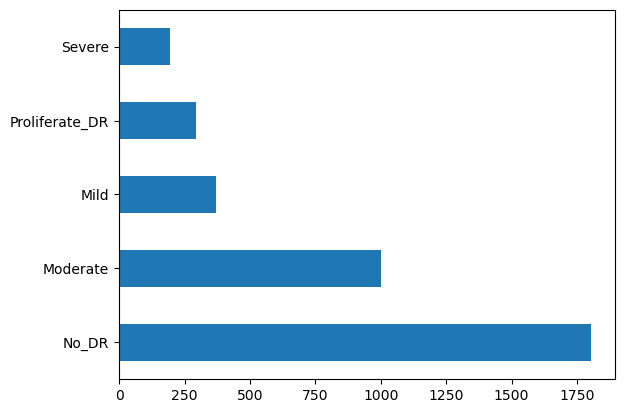

In [ ]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

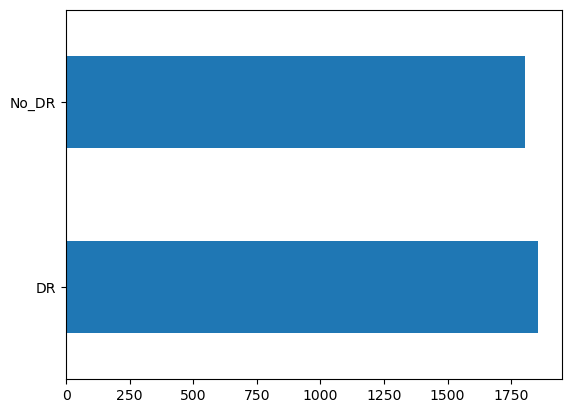

In [ ]:
df['binary'].value_counts().plot(kind='barh')

#### Data Preprocessing

In [ ]:
data = []
labels = []
width, height = 224, 224

# Retrieve the paths of all images in the 'data' directory
imagePaths = list(paths.list_images('data'))

# Loop over each image path
for imagePath in imagePaths:
    # Extract the label from the image path
    label = imagePath.split(os.path.sep)[-2]

    # Load and preprocess the image
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)

    # Append the image and label to the data and labels lists
    data.append(image)
    labels.append(label)

# Convert the data and labels lists to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Perform label binarization on the labels array
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

#Shuffle the data and labels arrays in unison
data, labels = shuffle(data, labels)

# Print the shapes of the data and labels arrays
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (3662, 224, 224, 3)
Labels shape: (3662, 5)


In [ ]:
# Normalizing the Data
data = data / 255.0

### Splitting Data to Training , Validation and Testing Sets

###### 20 % of data will be used for testing

###### 80 % of data will be used for training the model

###### 20 % of the training images will be used for validation

In [ ]:
data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=.2)

data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=.2)

print("Train images:",data_train.shape)
print("Test images:",data_test.shape)
print("Validate images:",data_val.shape)

print("Train label:",label_train.shape)
print("Test label:",label_test.shape)
print("Validate label:",label_val.shape)

Train images: (2343, 224, 224, 3)
Test images: (733, 224, 224, 3)
Validate images: (586, 224, 224, 3)
Train label: (2343, 5)
Test label: (733, 5)
Validate label: (586, 5)


This means that 2343 images are used for training , 733 for testing and 586 for validating

#### Preparing The Model

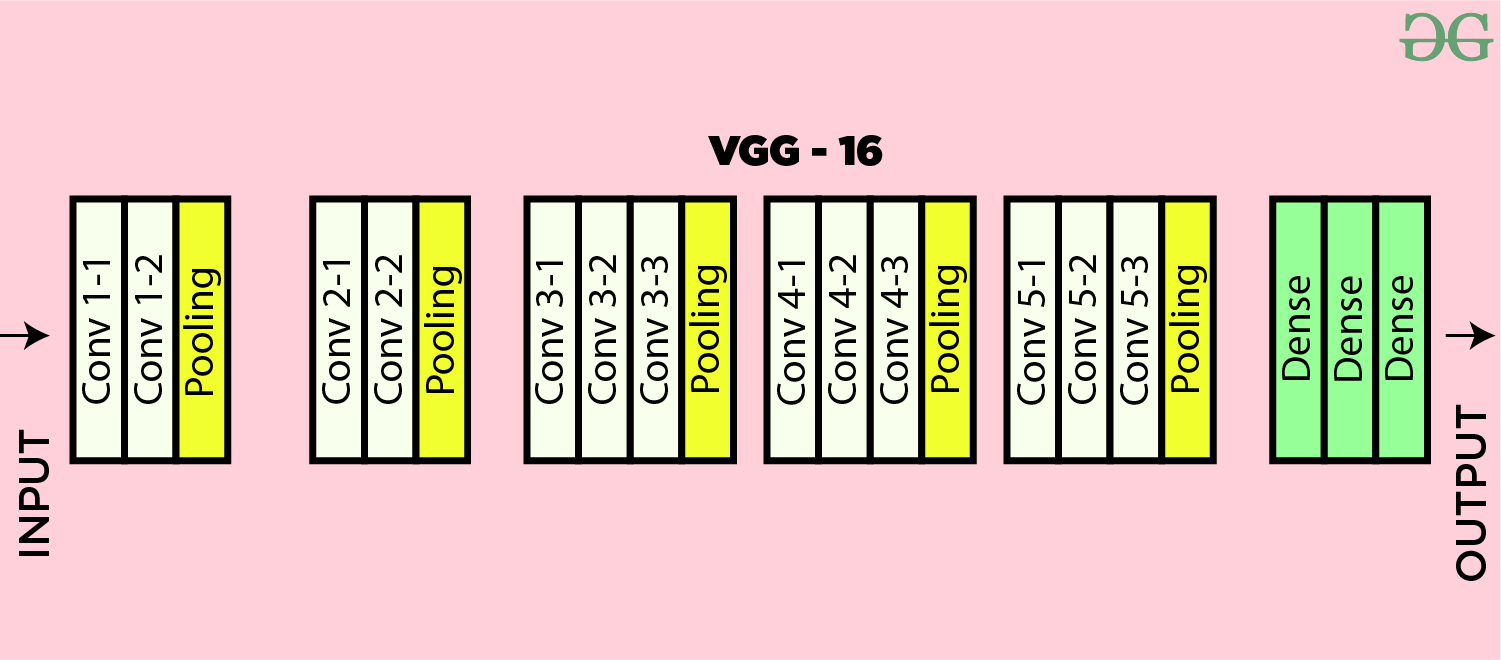

In [ ]:

image_path = "images/VGG16.jpg"
Image(filename=image_path)

In [ ]:

# Building the model

model = tf.keras.Sequential([

    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),

    layers.Dense(32, activation = 'relu'),

    layers.Dropout(0.15),

    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','binary_accuracy'])

callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(data_train , label_train , epochs=20 , batch_size=64,
                    validation_data=(data_val,label_val), verbose=1, callbacks = callbacks)

Epoch 1/20
37/37 [==============================] - 8s 206ms/step - loss: 0.6671 - acc: 0.3406 - binary_accuracy: 0.8044 - val_loss: 0.6320 - val_acc: 0.3754 - val_binary_accuracy: 0.8000
Epoch 2/20
37/37 [==============================] - 8s 226ms/step - loss: 0.4138 - acc: 0.5134 - binary_accuracy: 0.8652 - val_loss: 0.5113 - val_acc: 0.4983 - val_binary_accuracy: 0.8000
Epoch 3/20
37/37 [==============================] - 8s 207ms/step - loss: 0.3726 - acc: 0.5638 - binary_accuracy: 0.8678 - val_loss: 0.4579 - val_acc: 0.4983 - val_binary_accuracy: 0.8072
Epoch 4/20
37/37 [==============================] - 5s 140ms/step - loss: 0.3469 - acc: 0.6372 - binary_accuracy: 0.8780 - val_loss: 0.4354 - val_acc: 0.4983 - val_binary_accuracy: 0.8235
Epoch 5/20
37/37 [==============================] - 8s 217ms/step - loss: 0.3298 - acc: 0.6620 - binary_accuracy: 0.8814 - val_loss: 0.4153 - val_acc: 0.4983 - val_binary_accuracy: 0.8666
Epoch 6/20
37/37 [==============================] - 8s 208ms

In [ ]:

# Save the training history
with open("train_history.json", "w") as json_file:
    json.dump(history.history, json_file)

# Save the trained model
model.save("model.h5")

In [ ]:
def plot_curves(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    acc = history["acc"]
    val_acc = history["val_acc"]

    if "accuracy" in history:
        accuracy = history["accuracy"]
        val_accuracy = history["val_accuracy"]
    elif "binary_accuracy" in history:
        accuracy = history["binary_accuracy"]
        val_accuracy = history["val_binary_accuracy"]

    epochs = range(len(loss))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, acc, label="training_acc")
    plt.plot(epochs, val_acc, label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


In [ ]:
import json
from tensorflow.keras.models import load_model

# Load the training history from JSON file
with open("training_history.json", "r") as json_file:
    history = json.load(json_file)

# Load the trained model
model = load_model("My_model.h5")

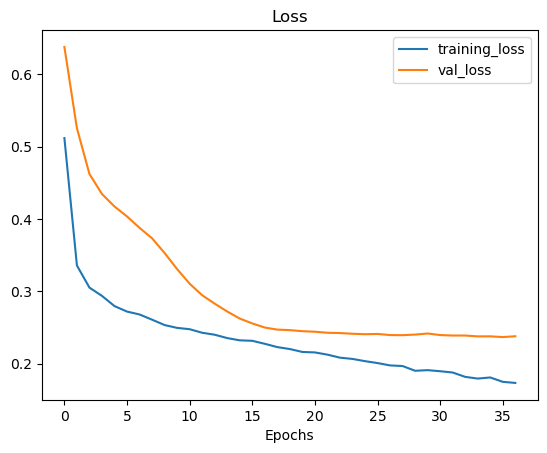

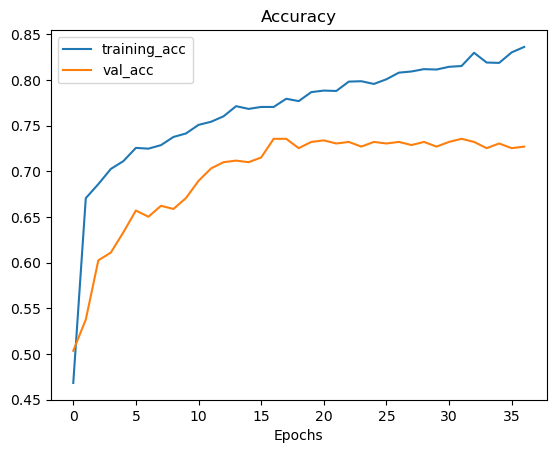

In [ ]:
plot_curves(history)

In [ ]:
score = model.evaluate(data_test,label_test)

23/23 [==============================] - 1s 19ms/step - loss: 0.2143 - acc: 0.7735 - binary_accuracy: 0.9214


##### Predicting Test Set

In [ ]:
pred = model.predict(data_test)
pred = np.argmax(pred,axis=1)

23/23 [==============================] - 0s 19ms/step


[0 0 1 0 0] --> No_DR ----
   [1 0 0 0 0] --> Mild ----
   [0 1 0 0 0] --> Moderate ----
   [0 0 0 0 1] --> Severe ----
   [0 0 0 1 0] --> Proliferate_DR


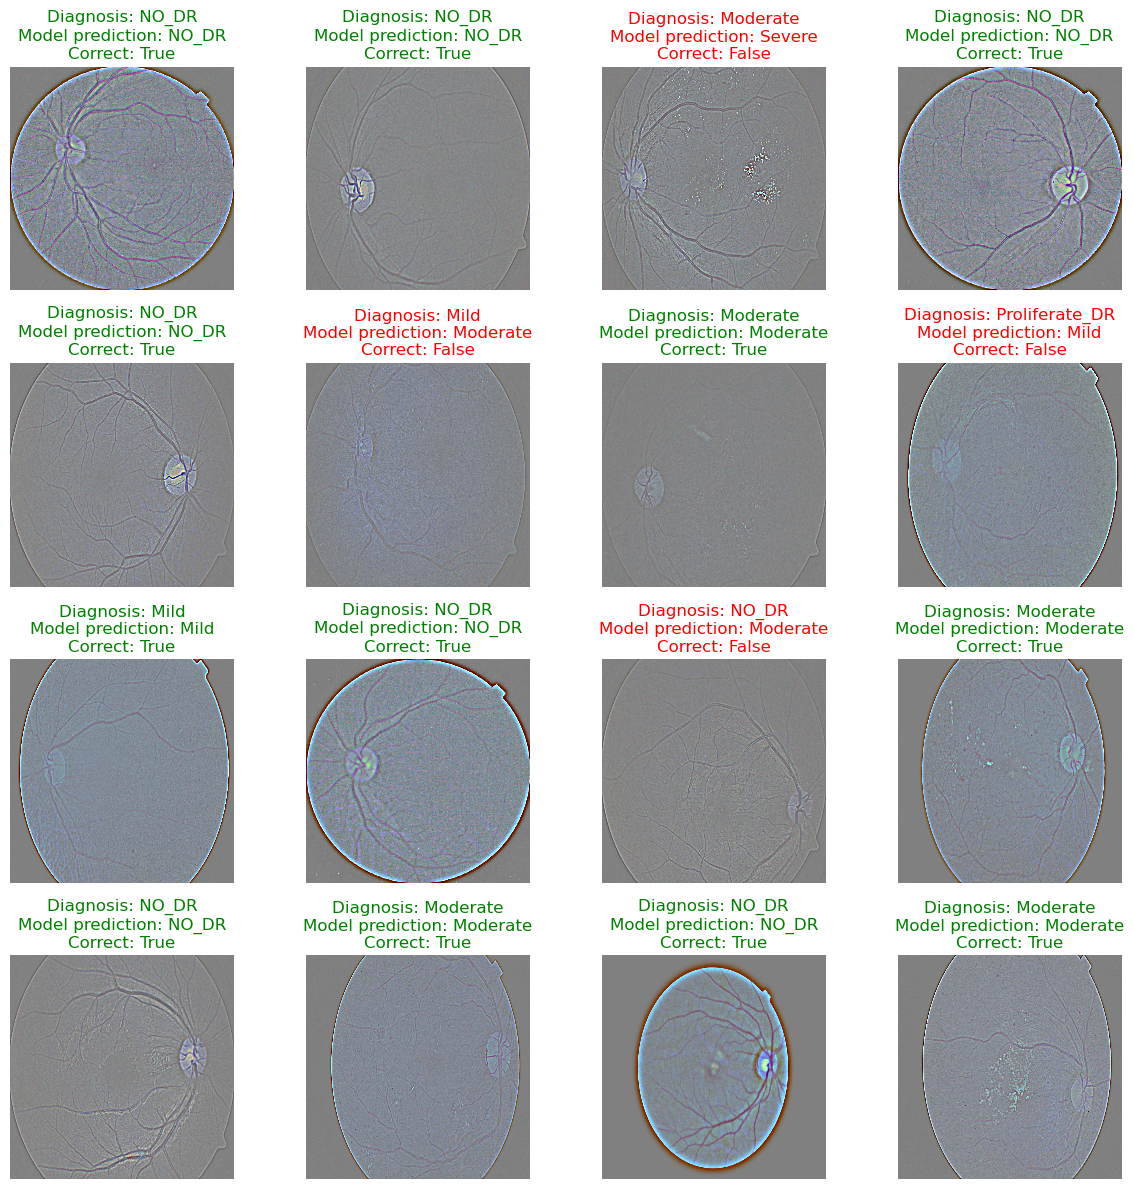

In [ ]:
import random

# Select 10 random indices
random_indices = random.sample(range(len(data_test)), 16)
predictions = ["Mild", "Moderate", "NO_DR", "Proliferate_DR", "Severe"]

# Create a subplot with 4 rows and 4 columns
plt.subplots(4, 4, figsize=(12, 12))

# Iterate over the selected indices and display the images
for i, index in enumerate(random_indices):
    img = data_test[index]
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    plt.subplot(4, 4, i+1)
    plt.imshow(RGBImg)
    plt.axis('off')

    true_label = label_test[index]
    predicted_label = predictions[pred[index]]

    if (true_label == [0, 0, 1, 0, 0]).all():
        true_diagnosis = "NO_DR"
    elif (true_label == [1, 0, 0, 0, 0]).all():
        true_diagnosis = "Mild"
    elif (true_label == [0, 1, 0, 0, 0]).all():
        true_diagnosis = "Moderate"
    elif (true_label == [0, 0, 0, 0, 1]).all():
        true_diagnosis = "Severe"
    elif (true_label == [0, 0, 0, 1, 0]).all():
        true_diagnosis = "Proliferate_DR"
    else:
        true_diagnosis = "Unknown"

    is_correct = true_diagnosis == predicted_label

    # Set the color based on the correctness of the prediction
    color = 'green' if is_correct else 'red'

    plt.title(f"Diagnosis: {true_diagnosis}\nModel prediction: {predicted_label}\nCorrect: {is_correct}", color=color)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



In [ ]:
# Function to predict the image
def predict_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img = np.array(img) / 255.0
    predict = model.predict(np.array([img]))
    pred = np.argmax(predict, axis=1)
    prediction = predictions[pred[0]]
    return prediction

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np

# Function to handle the button click event
def import_image():
    # Open a file dialog to choose an image file
    image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])

    # Check if an image was selected
    if image_path:
        # Clear the canvas
        canvas.delete("all")

        # Display the selected image on the canvas
        img = Image.open(image_path)
        img.thumbnail((500, 500))
        img = ImageTk.PhotoImage(img)
        canvas.create_image(0, 0, anchor="nw", image=img)
        canvas.image = img

        # Predict the image and display the result
        prediction = predict_image(image_path)
        result_label.config(text=f"Predicted: {prediction}")

# Create the main window
window = tk.Tk()
window.title("Image Prediction")

# Create a canvas to display the image
canvas = tk.Canvas(window, width=400, height=400)
canvas.pack()

# Create a button to import an image
import_button = tk.Button(window, text="Import Image", command=import_image)
import_button.pack(pady=10)

# Create a label to display the prediction result
result_label = tk.Label(window, text="No image selected", font=("Arial", 16))
result_label.pack()

# Start the main event loop
window.mainloop()


1/1 [==============================] - 0s 18ms/step
